In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sax
from simphony.quantum import QuantumSim,compose_qstate,CoherentState,SqueezedState
from functools import partial
import jax
import quantp as qp
import thewalrus as tw
from simphony.quantum import plot_quantum_result
from simphony.classical import ClassicalSim
from scipy.special import factorial
import jax.numpy as jnp
from scipy.stats import multivariate_normal
from thewalrus import _hafnian as hf
from thewalrus.quantum.conversions import Amat,Qmat





INFO:tensorflow:Restoring parameters from c:\Users\akhil\Miniconda3\Lib\site-packages\SiPANN\ANN\TIGHT_ANGLE_GAP/model
INFO:tensorflow:Restoring parameters from c:\Users\akhil\Miniconda3\Lib\site-packages\SiPANN\ANN\TIGHT_ANGLE_STRAIGHT/model
INFO:tensorflow:Restoring parameters from c:\Users\akhil\Miniconda3\Lib\site-packages\SiPANN\ANN\TIGHT_ANGLE_BENT_RAND/model


In [927]:
from gbs_func import phot_cir,trans,sub_mat

In [818]:


def one_mode_plot(mu,cov,ax,row,col):
   
    means=mu
    cov=cov

    # fig, ax = plt.subplots()
    x_max = means[0]+5
    y_max = means[1]+5
    r_max = jnp.max(jnp.array((x_max, y_max)))

    x_min = means[0]-5
    y_min = means[1]-5
    r_min = jnp.min(jnp.array((x_min, y_min)))

    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
   

    # x_range = (r_min, r_max)
    # y_range = (r_min, r_max)
    n=100
    x = jnp.linspace(x_range[0], x_range[1], n)
    y = jnp.linspace(y_range[0], y_range[1], n)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))
    dist = multivariate_normal(means, cov)
    pdf = dist.pdf(pos)
    ax[row,col].contourf(X, Y, pdf)
    ax[row,col].set_aspect("equal")
    ax[row,col].set_xlabel("X")
    ax[row,col].set_ylabel("P")
    return ax[row,col]



def mode_plot(res):
    mode=res.n_ports
    N=mode*2

    means=np.array(res.means[0])
    cov=res.cov

    u=1
    fig_ind=1
    ind=int(mode/2)
    ind=int(np.sqrt(mode))
    fig,ax=plt.subplots(ind,ind,figsize=(10,10))
    for i in range(res.n_ports):
        
        # ax=plt.subplot(ind,ind,i+1)
        mu=[means[i],means[i+N]]
        covar=np.array([[cov[u][i][i],cov[u][i][i+1]],
             [cov[u][i+1][i],cov[u][i+1][i+1]]])
        
    # Calculate row and column index
        row = i // 4
        col = i % 4
        
        one_mode_plot(mu,covar,ax,row,col)
    plt.tight_layout()
    plt.show

In [819]:
# theta_arr=np.random.rand(28)
# phi_arr=np.random.rand(28)
# theta_arr=np.multiply(theta_arr,0.5)

In [820]:
def sampler(a,b,c,wl,theta_arr=None,phi_arr=None):
       ##circuit
    if theta_arr is None  :
        theta_arr=np.zeros(len(a))
        print('theta array is None')
    if phi_arr is None:
        phi_arr=np.zeros(len(a))
        print('phi array is None')
    cir,info=sax.circuit(
        netlist={
            "instances":a,
            "connections":b,
            "ports":c
        },
        models={'SU2':partial(qp.trr)}) 
    
    su_dict={}
    i=0
    for key in range(len(a)):
        su_dict[key]={"theta":theta_arr[i],"phi":phi_arr[i]}
        i+=1
    
    val=cir(wl=wl,    S1=su_dict[0],
                      S2=su_dict[1],
                      S3=su_dict[2],
                      S4=su_dict[3],
                      S5=su_dict[4],
                      S6=su_dict[5],
                      
                      
    )
    return val


In [821]:
inst,conn,ports=phot_cir(4,4)
r=sampler(inst,conn,ports,wl=1.55)

theta array is None
phi array is None


In [822]:
U = np.array([
 [ 0.219546940711-0.256534554457j, 0.611076853957+0.524178937791j,
    -0.102700187435+0.474478834685j,-0.027250232925+0.03729094623j],
 [ 0.451281863394+0.602582912475j, 0.456952590016+0.01230749109j,
    0.131625867435-0.450417744715j, 0.035283194078-0.053244267184j],
 [ 0.038710094355+0.492715562066j,-0.019212744068-0.321842852355j,
    -0.240776471286+0.524432833034j,-0.458388143039+0.329633367819j],
 [-0.156619083736+0.224568570065j, 0.109992223305-0.163750223027j,
    -0.421179844245+0.183644837982j, 0.818769184612+0.068015658737j]
])

In [823]:
def haar_random_unitary(n):
   
    U = np.random.randn(n, n) + 1j * np.random.randn(n, n)    
    Q, R = np.linalg.qr(U)   
    d = np.diagonal(R)
    ph = d / np.abs(d)
    Q = np.multiply(Q, ph, Q)    
    return Q

def clements_decomposition(U):

    n = U.shape[0]
    theta = []
    phi = []    
    V = U.copy()
    for i in range(n-1):
        for j in range(i+1, n):
            a = V[i,i]
            b = V[j,i]
            r = np.sqrt(np.abs(a)**2 + np.abs(b)**2)
            theta_ij = 2 * np.arctan2(np.abs(b), np.abs(a))
            phi_ij = np.angle(b) - np.angle(a)
            theta.append(theta_ij)
            phi.append(phi_ij)
            c = a / r
            s = b / r
            V[:,i] = c * V[:,i] + np.conj(s) * V[:,j]
            V[:,j] = -s * V[:,i] + c * V[:,j]

    theta = np.mod(theta, 2 * np.pi)
    phi = np.mod(phi, 2 * np.pi)    
    return np.array(theta), np.array(phi)

def angles(U,n):
    theta_arr, phi_arr = clements_decomposition(U)
    theta_arr=np.multiply(theta_arr,(1/(2*np.pi)))
    phi_arr=np.abs(np.multiply(phi_arr,(1/(2*np.pi))))
    return theta_arr, phi_arr

In [824]:
angles(U,6)

(array([0.36579584, 0.03879647, 0.03613739, 0.05158392, 0.03672835,
        0.21509533]),
 array([0.28503469, 0.64075221, 0.8571156 , 0.8733097 , 0.75494171,
        0.1147252 ]))

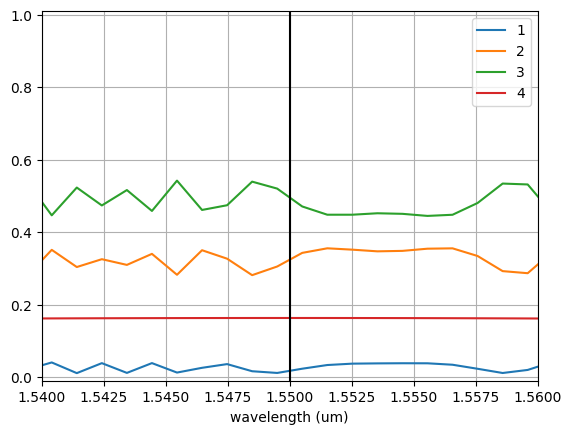

In [825]:
wl=np.linspace(1.5,1.6,100)
theta_arr,phi_arr=angles(U,6)

f=plt.figure()

k=1

# theta_arr=np.random.rand(28)
# theta_arr=np.multiply(0.5,theta_arr)
# theta_arr=np.ones(28)*0.125


sim3=ClassicalSim(ckt=sampler,wl=wl,a=inst,b=conn,c=ports,theta_arr=theta_arr,phi_arr=phi_arr)
laser_1 = sim3.add_laser(ports=["int1"], power=1.0)
laser_2 = sim3.add_laser(ports=["inb1"], power=0.0)
laser_3 = sim3.add_laser(ports=["int2"], power=0.0)
laser_4 = sim3.add_laser(ports=["inb2"], power=0.0)

# laser_5 = sim3.add_laser(ports=["int3"], power=0.0)
# laser_6 = sim3.add_laser(ports=["inb3"], power=0.0)
# laser_7 = sim3.add_laser(ports=["int4"], power=0.0)
# laser_8 = sim3.add_laser(ports=["inb4"], power=0.0)


detector_1 = sim3.add_detector(ports=["outt1"])
detector_2 = sim3.add_detector(ports=["outb1"])
detector_3 = sim3.add_detector(ports=["outt2"])
detector_4 = sim3.add_detector(ports=["outb2"])

# detector_5 = sim3.add_detector(ports=["outt3"])
# detector_6 = sim3.add_detector(ports=["outb3"])
# detector_7 = sim3.add_detector(ports=["outt4"])
# detector_8 = sim3.add_detector(ports=["outb4"])
result = sim3.run()
        



plt.plot(wl, np.abs(result.sdict['outt1'])**2, label='1')
plt.plot(wl, np.abs(result.sdict['outb1'])**2, label='2')
plt.plot(wl, np.abs(result.sdict['outt2'])**2, label='3')
plt.plot(wl, np.abs(result.sdict['outb2'])**2, label='4')

# plt.plot(wl, np.abs(result.sdict['outt3'])**2, label='5')
# plt.plot(wl, np.abs(result.sdict['outb3'])**2, label='6')
# plt.plot(wl, np.abs(result.sdict['outt4'])**2, label='7')
# plt.plot(wl, np.abs(result.sdict['outb4'])**2, label='8')

plt.axvline(x=1.55, color='k')
plt.legend()
plt.grid()
plt.ylim([-0.01,1.01])
plt.xlim([1.49,1.61])
plt.xlim([1.54,1.56])
# plt.title('theta-phi= '+ '('+str(i1)+','+ str(j1)+'), ('+str(i2)+','+str(j2)+'), ('+str(i3)+','+str(j3)+')')
plt.xlabel("wavelength (um)")
k=k+1


 


In [826]:

mean_photon_number = 1


r = np.arcsinh(np.sqrt(mean_photon_number))

print("Sq  param: ")
print(r)


Sq  param: 
0.881373587019543


In [1168]:
r=0.6
s_sq = np.sinh(r)**2
alpha_sq = 1 - s_sq

if alpha_sq >= 0:
    alpha = np.sqrt(alpha_sq)
else:
    alpha = None


print(alpha)


0.7711499311663151


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


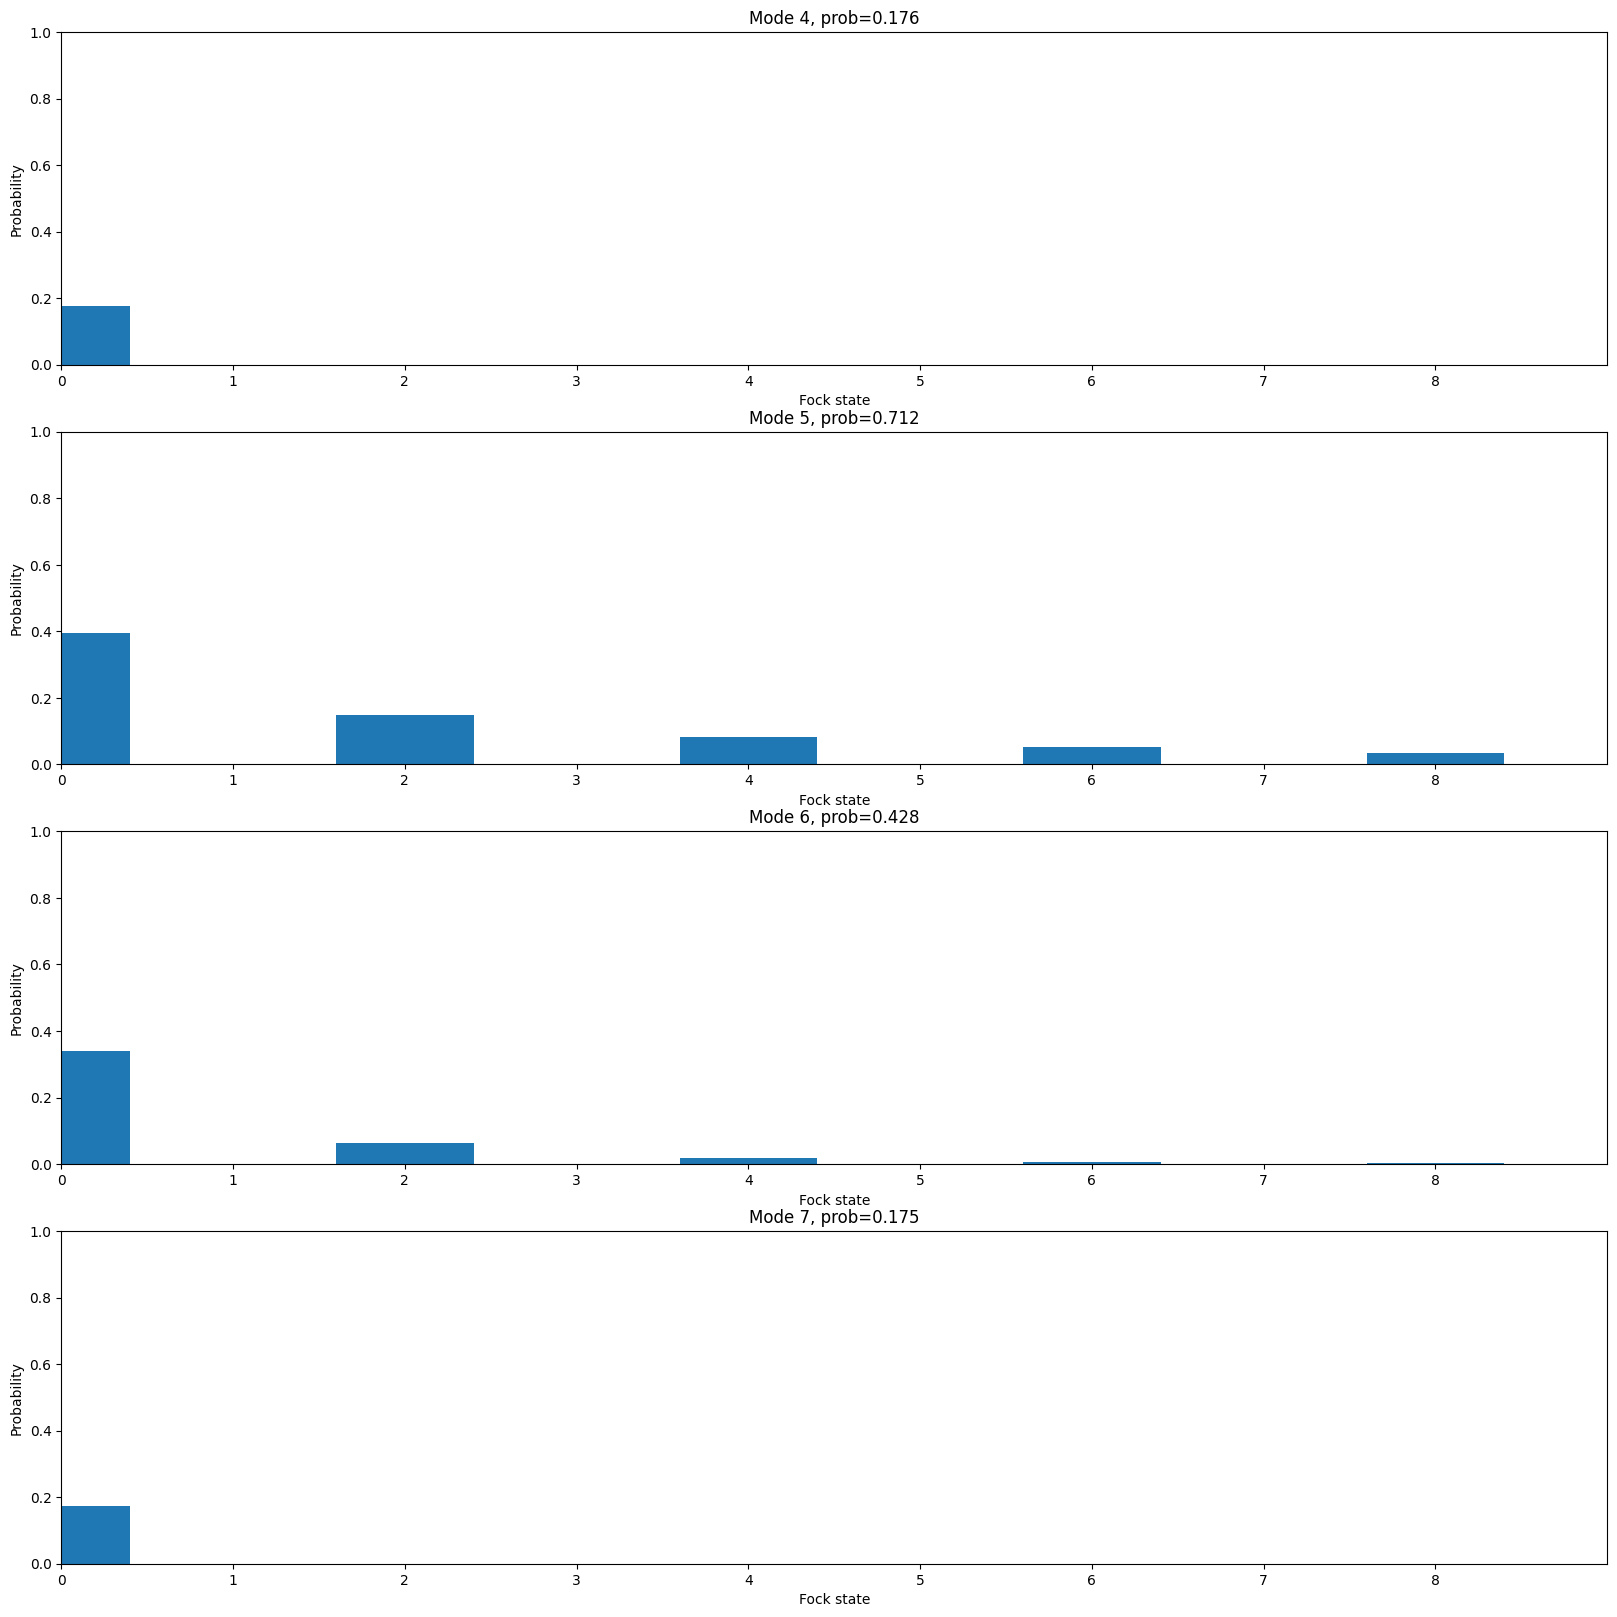

In [1413]:
wl=1.55
a=0
r=0.881373587019543
r=1.55
# a=0.771
# a=1.5

sim=QuantumSim(ckt=sampler,wl=wl,a=inst,b=conn,c=ports,theta_arr=theta_arr,phi_arr=phi_arr)

i1=SqueezedState(port="int1",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.50)
i2=SqueezedState(port="inb1",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.50)
i3=SqueezedState(port="int2",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.50)
i4=SqueezedState(port="inb2",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.50)
# i5=SqueezedState(port="int3",r=r,alpha=a*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
# i6=SqueezedState(port="inb3",r=r,alpha=a*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
# i7=SqueezedState(port="int4",r=r,alpha=a*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)
# i8=SqueezedState(port="inb4",r=r,alpha=a*np.exp(2*np.pi*0.25),phi=2*np.pi*0.0)

qstate=compose_qstate(i1,i2,i3,i4)
# ,i5,i6,i7,i8

sim.add_qstate(qstate=qstate)
res=sim.run()
res_state=res.state()
# i2.plot_mode(mode=0)



fig,ax=plt.subplots(4,1,figsize=(16,16))
cutoff=9
k=0
ind=0
pdf=np.zeros((4,cutoff))
for i in range(4,8):
        means, cov = res_state.modes(i)
        print(means)
        fock_amp = tw.quantum.state_vector(means, cov, cutoff=cutoff, hbar=1/2, check_purity=False)
        # ax=plt.subplot(2,2,i-1)

        prob=np.sum(abs(fock_amp)**2) 
        prob=round(prob,3)   
        p_arr=np.array(abs(fock_amp)**2)
        # p_arr=p_arr/np.sum(p_arr)
        # prob=round(np.sum(p_arr),3)
        # if k>=8:
        pdf[k]=p_arr
        #  ind+=1

        # ax[i].set_title(f'Mode {i}, prob={prob}')
       

        # ax[k].bar(range(len(fock_amp)), abs(fock_amp) ** 2)
        ax[k].bar(range(len(fock_amp)), p_arr)
        ax[k].set_xticks(range(len(fock_amp)))
        ax[k].set_xlabel("Fock state")
        ax[k].set_ylabel("Probability")
        ax[k].set_ylim([0, 1])
        ax[k].set_xlim([0, cutoff])
        ax[k].set_title(f'Mode {i}, prob={prob}')
        k+=1

# plt.tight_layout()
plt.tight_layout(pad=0.1)
plt.show()

In [1414]:
res_state.modes

<bound method QuantumState.modes of <simphony.quantum.QuantumState object at 0x000002379D196D20>
Convention: xxpp
Means: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Cov: 
[[ 2.50000000e-01 -1.72865194e-15  7.77156117e-16 ...  8.99354933e-09
   6.01544529e-11 -4.22403616e-10]
 [-1.72865194e-15  2.50000000e-01 -1.76508114e-15 ... -3.31960233e-09
   2.04930564e-08  2.86853941e-10]
 [ 7.77156117e-16 -1.76508114e-15  2.50000000e-01 ...  5.92115209e-09
   6.23734703e-09 -7.69033255e-09]
 ...
 [ 8.99354933e-09 -3.31960233e-09  5.92115209e-09 ...  2.50000000e-01
   4.25007252e-17 -1.44328993e-15]
 [ 6.01544529e-11  2.04930564e-08  6.23734703e-09 ...  4.25007252e-17
   2.50000000e-01  3.59955121e-16]
 [-4.22403616e-10  2.86853941e-10 -7.69033255e-09 ... -1.44328993e-15
   3.59955121e-16  2.50000000e-01]]>

In [1415]:
means=xxpp_to_xpxp(res_state.means)[8:16]
means=xpxp_to_xxpp(means)
means

Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [1416]:
import pandas as pd
from thewalrus.quantum.conversions import Amat,Qmat
from simphony.quantum import xxpp_to_xpxp,xpxp_to_xxpp

In [1417]:
Cv=res_state.cov
# cv=xpxp_to_xxpp(cv)
cv=np.array(Cv.copy())
cv=xxpp_to_xpxp(cv)
cv[(cv) < 1e-10] = 0
# V=cv[8:16,8:16]
fd=pd.DataFrame(cv[:,4:24])
fd1=pd.DataFrame(cv[:,:8])
fd2=pd.DataFrame(cv[:,8:16])
fd3=pd.DataFrame(cv[:,16:24])
fd4=pd.DataFrame(cv[:,24:32])
# print(fd1)

In [1418]:
out_cov=cv[8:16,8:16]
gh=pd.DataFrame(out_cov)
gh


,0,1,2,3,4,5,6,7
0,2.049326,0.000000,0.215550,0.000000,0.396995,0.000000,0.000000,1.916393
1,0.000000,3.511424,0.000000,0.000000,0.000000,0.000000,1.916393,1.621356
2,0.215550,0.000000,5.319493,0.000000,0.000000,0.050921,0.102914,0.000000
3,0.000000,0.000000,0.000000,0.241257,0.050921,0.070701,0.000000,0.000000
4,0.396995,0.000000,0.000000,0.050921,0.972549,1.935232,0.000000,0.613690
5,0.000000,0.000000,0.050921,0.070701,1.935232,4.588201,0.613690,0.135069
6,0.000000,1.916393,0.102914,0.000000,0.000000,0.613690,1.938029,0.000000
7,1.916393,1.621356,0.000000,0.000000,0.613690,0.135069,0.000000,3.622721


In [1419]:
new_cov=xpxp_to_xxpp(out_cov)
pd.DataFrame(new_cov)

,0,1,2,3,4,5,6,7
0,2.049326,0.215550,0.396995,0.000000,0.000000,0.000000,0.000000,1.916393
1,0.215550,5.319493,0.000000,0.102914,0.000000,0.000000,0.050921,0.000000
2,0.396995,0.000000,0.972549,0.000000,0.000000,0.050921,1.935232,0.613690
3,0.000000,0.102914,0.000000,1.938029,1.916393,0.000000,0.613690,0.000000
4,0.000000,0.000000,0.000000,1.916393,3.511424,0.000000,0.000000,1.621356
5,0.000000,0.000000,0.050921,0.000000,0.000000,0.241257,0.070701,0.000000
6,0.000000,0.050921,1.935232,0.613690,0.000000,0.070701,4.588201,0.135069
7,1.916393,0.000000,0.613690,0.000000,1.621356,0.000000,0.135069,3.622721


In [1420]:
def sss(cov):
    n=len(cov)//2
    I=np.identity(n,dtype=complex)
    iI=(1j)*I
    f=np.block([[I,iI],[I,-iI]])
    
    f=(1/np.sqrt(2))*f
    sigma=f@cov@((f.conj()).T)
    return sigma

pd.DataFrame(sss(new_cov))

,0,1,2,3,4,5,6,7
0,2.780375+0.000000j,0.107775+0.000000j,0.198498+0.000000j,0.810678+0.000000j,-0.731049+0.000000j,0.107775+0.000000j,0.198498+0.000000j,-0.810678+1.916393j
1,0.107775+0.000000j,2.780375+0.000000j,0.035351+0.000000j,0.051457+0.000000j,0.107775+0.000000j,2.539118+0.000000j,-0.035351+0.050921j,0.051457+0.000000j
2,0.198498+0.000000j,0.035351-0.000000j,2.780375-0.000000j,0.067535-0.000000j,0.198498+0.000000j,-0.035351+0.050921j,-1.807826+1.935232j,-0.067535+0.613690j
3,0.810678-0.000000j,0.051457+0.000000j,0.067535+0.000000j,2.780375+0.000000j,-0.810678+1.916393j,0.051457+0.000000j,-0.067535+0.613690j,-0.842346+0.000000j
4,-0.731049+0.000000j,0.107775+0.000000j,0.198498+0.000000j,-0.810678-1.916393j,2.780375+0.000000j,0.107775+0.000000j,0.198498+0.000000j,0.810678-0.000000j
5,0.107775+0.000000j,2.539118+0.000000j,-0.035351-0.050921j,0.051457+0.000000j,0.107775+0.000000j,2.780375+0.000000j,0.035351-0.000000j,0.051457+0.000000j
6,0.198498+0.000000j,-0.035351-0.050921j,-1.807826-1.935232j,-0.067535-0.613690j,0.198498+0.000000j,0.035351+0.000000j,2.780375+0.000000j,0.067535+0.000000j
7,-0.810678-1.916393j,0.051457+0.000000j,-0.067535-0.613690j,-0.842346+0.000000j,0.810678+0.000000j,0.051457+0.000000j,0.067535-0.000000j,2.780375+0.000000j


In [1421]:
def F(cov):
    n=len(cov)//2
    I=np.identity(n,dtype=complex)
    iI=(1j)*I
    f=np.block([[I,iI],[I,-iI]])
    f=(1/np.sqrt(2))*f
    
    return f
mean=means
f=F(mean)
new_mean=f@mean

In [1422]:
def sigma(cov):
    n=len(cov)//2
    I=np.identity(n,dtype=complex)
    iI=(1j)*I
    f=np.block([[I,iI],[I,-iI]])
    f=(1/np.sqrt(2))*f
    sigma=f@cov@((f.conj()).T)
    return sigma

def xmat(N):
   
    I = np.identity(N)
    O = np.zeros_like(I)
    X = np.block([[O, I], [I, O]])
    return X


def qmat(cov,hbar=2):
    # qmat=np.ones((len(cov),len(cov)))*0.5
    qmat=np.eye(len(cov))*0.5
    q=cov+qmat
    return q

def amat(cov,hbar=2):
    N = len(cov) // 2
    X = xmat(N)

    # inverse Q matrix
    
    Q = qmat(cov, hbar=hbar)

    Qinv = np.linalg.inv(Q)

    # calculate Hamilton's A matrix: A = X.(I-Q^{-1})*
   
    I=np.eye(len(cov))
    i_minus_sigma_inv=I-Qinv
    # A =np.dot(X,i_minus_sigma).conj()f@cov@((f.conj()).T)
    A = X @ (np.identity(2 * N) - Qinv)
    # A = X @(i_minus_sigma_inv)
    return A

In [1423]:
from thewalrus import decompositions as dc
def decompose_cov(cov):
    cov=np.abs(cov)
    m = cov.shape[0] // 2
    D, S = dc.williamson(cov)
    T = S @ S.T 
    DmI = D - np.eye(2*m)
    DmI[abs(DmI) < 1e-11] = 0. # remove slightly negative values
    sqrtW = S @ np.sqrt(DmI)
    return T, sqrtW

In [1424]:

ff=sigma(new_cov)
is_symmetric(ff)
pd.DataFrame(amat(ff))


,0,1,2,3,4,5,6,7
0,-0.039317+0.317418j,0.008926-0.001099j,0.119010+0.034834j,-0.070677-0.511521j,0.275216+0.000000j,0.015418-0.001523j,0.028039-0.066631j,0.344693-0.050072j
1,0.008926-0.001099j,0.589858-0.000104j,-0.004146-0.027341j,0.006981+0.008301j,0.015418+0.001523j,0.237293-0.000000j,-0.003558-0.022877j,-0.002869-0.003045j
2,0.119010+0.034834j,-0.004146-0.027341j,-0.571832-0.626761j,-0.093535-0.161730j,0.028039+0.066631j,-0.003558+0.022877j,-0.029416-0.000000j,-0.088900-0.024769j
3,-0.070677-0.511521j,0.006981+0.008301j,-0.093535-0.161730j,-0.128886+0.327186j,0.344693+0.050072j,-0.002869+0.003045j,-0.088900+0.024769j,0.230164+0.000000j
4,0.275216-0.000000j,0.015418+0.001523j,0.028039+0.066631j,0.344693+0.050072j,-0.039317-0.317418j,0.008926+0.001099j,0.119010-0.034834j,-0.070677+0.511521j
5,0.015418-0.001523j,0.237293-0.000000j,-0.003558+0.022877j,-0.002869+0.003045j,0.008926+0.001099j,0.589858+0.000104j,-0.004146+0.027341j,0.006981-0.008301j
6,0.028039-0.066631j,-0.003558-0.022877j,-0.029416-0.000000j,-0.088900+0.024769j,0.119010-0.034834j,-0.004146+0.027341j,-0.571832+0.626761j,-0.093535+0.161730j
7,0.344693-0.050072j,-0.002869-0.003045j,-0.088900-0.024769j,0.230164-0.000000j,-0.070677+0.511521j,0.006981-0.008301j,-0.093535+0.161730j,-0.128886-0.327186j


In [1425]:
sigma_cov=sigma(new_cov)
q=qmat(sigma_cov)
det=np.linalg.det(q)
1/np.sqrt(np.abs(det))
# qq=np.linalg.inv(q)

0.05582806464281442

In [842]:
T,sq=decompose_cov(cv)

C:\Users\akhil\AppData\Local\Temp\ipykernel_4772\3386410453.py:9: RuntimeWarning: invalid value encountered in sqrt
  sqrtW = S @ np.sqrt(DmI)


In [1342]:
def F(cov):
    n=len(cov)//2
    I=np.identity(n,dtype=complex)
    iI=(1j)*I
    f=np.block([[I,iI],[I,-iI]])
    f=(1/np.sqrt(2))*f
    
    return f
mean=means
f=F(mean)
new_mean=f@mean

In [1343]:
s=sigma(new_cov)

In [1344]:
A=Amat(new_cov,hbar=1)
Q=Qmat(new_cov,hbar=1)
# Q=qmat(s)
# A=amat(s)
Q_inv=np.linalg.inv(Q)
# Q=qmat(s)
# A=amat(s)

In [1350]:
new_mean_H=(new_mean.conj()).T
exp_term=new_mean_H@Q_inv@new_mean
exp_term=np.exp(-0.5*exp_term).real

gamma=new_mean_H@Q_inv
loop_A=A.copy()
index=0
for g in gamma:
    loop_A[index,index]=g
    index+=1

det=np.linalg.det(Q)
sqrt=np.sqrt(det).real

P0=exp_term/sqrt
P0


0.028119526090202553

In [1373]:
def disp_prob(loop_A,ar,P0):
    fact=1
    for factor in ar:
        fact*=factorial(factor)      
    As=sub_mat(loop_A,ar)
    lhafn=lhaf(As)
    prob=P0*lhafn/(fact)
    if prob.real<0:
        prob=0
    return prob.real
    
    

In [1374]:
ar=[0,0,0,0]
disp_prob(loop_A,ar,P0)

0.028119526090202553

In [1369]:

As=sub_mat(loop_A,ar)
pd.DataFrame(As)


,0,1,2,3,4,5
0,0.519484-0.563438j,0.519484-0.563438j,0.015325+0.001295j,-0.083357-0.000000j,-0.083357-0.000000j,0.016589-0.000651j
1,0.519484-0.563438j,0.519484-0.563438j,0.015325+0.001295j,-0.083357-0.000000j,-0.083357-0.000000j,0.016589-0.000651j
2,0.015325+0.001295j,0.015325+0.001295j,-0.845651-0.359728j,0.016589+0.000651j,0.016589+0.000651j,-0.130510-0.000000j
3,-0.083357-0.000000j,-0.083357-0.000000j,0.016589+0.000651j,0.519484+0.563438j,0.519484+0.563438j,0.015325-0.001295j
4,-0.083357-0.000000j,-0.083357-0.000000j,0.016589+0.000651j,0.519484+0.563438j,0.519484+0.563438j,0.015325-0.001295j
5,0.016589-0.000651j,0.016589-0.000651j,-0.130510-0.000000j,0.015325-0.001295j,0.015325-0.001295j,-0.845651+0.359728j


In [1208]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7
0,-0.084481+0.038001j,0.012401+0.000819j,0.033590+0.010305j,-0.095517-0.262167j,-0.446080-0.000000j,0.012578+0.000586j,0.019718-0.001250j,0.103395-0.004506j
1,0.012401+0.000819j,0.347482+0.000026j,-0.005377-0.006387j,0.006106+0.002257j,0.012578-0.000586j,-0.459920+0.000000j,0.003591-0.002098j,0.005562-0.001662j
2,0.033590+0.010305j,-0.005377-0.006387j,-0.250924-0.267497j,-0.009451-0.080179j,0.019718+0.001250j,0.003591+0.002098j,-0.473594+0.000000j,-0.005485+0.001086j
3,-0.095517-0.262167j,0.006106+0.002257j,-0.009451-0.080179j,-0.100365+0.039036j,0.103395+0.004506j,0.005562+0.001662j,-0.005485-0.001086j,-0.451669+0.000000j
4,-0.446080+0.000000j,0.012578-0.000586j,0.019718+0.001250j,0.103395+0.004506j,-0.084481-0.038001j,0.012401-0.000819j,0.033590-0.010305j,-0.095517+0.262167j
5,0.012578+0.000586j,-0.459920-0.000000j,0.003591+0.002098j,0.005562+0.001662j,0.012401-0.000819j,0.347482-0.000026j,-0.005377+0.006387j,0.006106-0.002257j
6,0.019718-0.001250j,0.003591-0.002098j,-0.473594+0.000000j,-0.005485-0.001086j,0.033590-0.010305j,-0.005377+0.006387j,-0.250924+0.267497j,-0.009451+0.080179j
7,0.103395-0.004506j,0.005562-0.001662j,-0.005485+0.001086j,-0.451669-0.000000j,-0.095517+0.262167j,0.006106-0.002257j,-0.009451+0.080179j,-0.100365-0.039036j


In [1212]:
gamma=new_mean_H@Q_inv
gamma
loop_A=A.copy()
index=0
for g in gamma:
    loop_A[index,index]=g
    index+=index

In [1217]:
from thewalrus import loop_hafnian as lhaf 

lhaf(loop_A)*exp_term

(0.32092960820620153+0.003857418531468023j)

In [1199]:
A=Amat(new_cov)
Q=Qmat(new_cov,hbar=1)
# Q=Qmat(new_cov)
Q_inv=np.linalg.inv(Q)
dt=abs(np.linalg.det(Q))
det=np.sqrt(dt)
1/det

1.6017980011369268

In [1196]:
# Q=qmat(new_cov)
# Q=qmat(out_cov)
A=amat(sigma_cov)
Q=qmat(sigma_cov)
# Q=Qmat(new_cov)

dt=np.linalg.det(Q)
det=np.sqrt(np.abs(dt))
d=1/det
abs(haf(A))*d
# pd.DataFrame(A)
# haf(A)

0.01464692649032005

In [1121]:
a=amat(sigma_cov)
pd.DataFrame(abs(a))


,0,1,2,3,4,5,6,7
0,0.162205,0.013760,0.083773,0.111018,0.218819,0.016007,0.054429,0.110435
1,0.013760,0.716549,0.012622,0.033656,0.016007,0.144604,0.009132,0.020968
2,0.083773,0.012622,0.354578,0.012932,0.054429,0.009132,0.150656,0.012576
3,0.111018,0.033656,0.012932,0.140225,0.110435,0.020968,0.012576,0.234453
4,0.218819,0.016007,0.054429,0.110435,0.162205,0.013760,0.083773,0.111018
5,0.016007,0.144604,0.009132,0.020968,0.013760,0.716549,0.012622,0.033656
6,0.054429,0.009132,0.150656,0.012576,0.083773,0.012622,0.354578,0.012932
7,0.110435,0.020968,0.012576,0.234453,0.111018,0.033656,0.012932,0.140225


In [1122]:
A=Amat(new_cov,hbar=1)
pd.DataFrame(abs(A))


,0,1,2,3,4,5,6,7
0,0.162205,0.013760,0.083773,0.111018,0.218819,0.016007,0.054429,0.110435
1,0.013760,0.716549,0.012622,0.033656,0.016007,0.144604,0.009132,0.020968
2,0.083773,0.012622,0.354578,0.012932,0.054429,0.009132,0.150656,0.012576
3,0.111018,0.033656,0.012932,0.140225,0.110435,0.020968,0.012576,0.234453
4,0.218819,0.016007,0.054429,0.110435,0.162205,0.013760,0.083773,0.111018
5,0.016007,0.144604,0.009132,0.020968,0.013760,0.716549,0.012622,0.033656
6,0.054429,0.009132,0.150656,0.012576,0.083773,0.012622,0.354578,0.012932
7,0.110435,0.020968,0.012576,0.234453,0.111018,0.033656,0.012932,0.140225


In [1123]:
np.allclose(a, A, atol=1e-8)

True

In [1130]:
from thewalrus import hafnian as haf
(haf(A))

(-0.00187881870732861-2.168404344971009e-19j)

In [1054]:
def probability(A,ar,det):
    fact=1
    for factor in ar:
        fact*=factorial(factor)      
    As=sub_mat(A,ar)
    hafn=haf(As).real
    if hafn<0:
        hafn=0
    det=np.abs(det)
    prob=hafn/(det*fact)
    return prob

In [1000]:
def is_symmetric(matrix):
    return np.allclose(matrix, matrix.T)

is_symmetric(A)

True

In [1295]:

def trans(A,arr):
    
    sum=np.sum(arr)
    D=np.eye(int(sum),dtype=complex)
    j=0
    d=0 
    for a in arr:   
        if a==0:
            j+=1
        else:
            one=np.ones((a,a),dtype=complex)*A[j,j]
            D[d:d+a,d:d+a]=one
            d+=a
            j+=1

    new_dict={}
    for (i, j), value in np.ndenumerate(A):
        new_dict[(value.real,value.imag)]=[i,j]
    

    new_mat=D.copy()
    for (i, j), value in np.ndenumerate(D):
        if value==0*(1+1j):
            
            a=D[i,i]
            b=D[j,j]
            a_ind = new_dict[(a.real,a.imag)]
            b_ind = new_dict[(b.real,b.imag)]
        
            for key, (d_i, d_j) in new_dict.items():
                if (d_i, d_j) == (a_ind[0], b_ind[0]):
                    
                    new_mat[i, j] = key[0]+1j*key[1]

    return new_mat

## repearing for first and fourth quad
def sub_mat(mat,arr):
    n=int(mat.shape[0]/2)
    A=mat[:n,:n]
    B=mat[:n,n:]
    C=mat[n:,n:]

    a_new=trans(A,arr)
    b_new=trans(B,arr)
    c_new=trans(C,arr)

    
    s=a_new.shape[0]
    As=np.eye(2*s,dtype=complex)
    As[:s,:s]=a_new
    As[s:,:s]=b_new
    As[:s,s:]=b_new.T
    As[s:,s:]=c_new
    return As

In [1056]:
pd.DataFrame(A)
# is_symmetric(np.abs(A))

,0,1,2,3,4,5,6,7
0,0.106708-0.135656j,-0.014931+0.002825j,-0.057904-0.054858j,0.118604+0.028582j,-0.100282-0.000000j,0.016086-0.000868j,0.048310+0.006252j,0.121302+0.005613j
1,-0.014931+0.002825j,-0.563578-0.236939j,0.010053+0.001765j,-0.008021-0.026271j,0.016086+0.000868j,-0.316065+0.000000j,0.007339+0.001867j,0.000477+0.012918j
2,-0.057904-0.054858j,0.010053+0.001765j,0.352840+0.003969j,0.008432+0.008351j,0.048310-0.006252j,0.007339-0.001867j,-0.144984+0.000000j,0.009887+0.006266j
3,0.118604+0.028582j,-0.008021-0.026271j,0.008432+0.008351j,0.122121-0.092693j,0.121302-0.005613j,0.000477-0.012918j,0.009887-0.006266j,-0.089241-0.000000j
4,-0.100282-0.000000j,0.016086+0.000868j,0.048310-0.006252j,0.121302-0.005613j,0.106708+0.135656j,-0.014931-0.002825j,-0.057904+0.054858j,0.118604-0.028582j
5,0.016086-0.000868j,-0.316065-0.000000j,0.007339-0.001867j,0.000477-0.012918j,-0.014931-0.002825j,-0.563578+0.236939j,0.010053-0.001765j,-0.008021+0.026271j
6,0.048310+0.006252j,0.007339+0.001867j,-0.144984-0.000000j,0.009887-0.006266j,-0.057904+0.054858j,0.010053-0.001765j,0.352840-0.003969j,0.008432-0.008351j
7,0.121302+0.005613j,0.000477+0.012918j,0.009887+0.006266j,-0.089241-0.000000j,0.118604-0.028582j,-0.008021+0.026271j,0.008432-0.008351j,0.122121+0.092693j


In [1062]:
ar=[1,0,0,0]
ass=sub_mat(A,ar)
import numpy as np
from thewalrus import hafnian as haf
probability(A,ar,det)
# haf(ass).real

# pd.DataFrame(ass)



0.0

In [939]:
import numpy as np
from thewalrus import hafnian

# Define the given matrix
matrix = np.array([[ 0.09561483+1.31027396e-01j, -0.01241681-5.92852783e-03j, 0.21881868-1.75952893e-18j,  0.01599575+5.92586856e-04j],
                   [-0.01241681-5.92852783e-03j, -0.6605786 +2.77631147e-01j, 0.01599575-5.92586856e-04j, -0.14460356+3.00257417e-18j],
                   [ 0.21881868-1.75952893e-18j,  0.01599575-5.92586856e-04j, 0.09561483-1.31027396e-01j, -0.01241681+5.92852783e-03j],
                   [ 0.01599575+5.92586856e-04j, -0.14460356+3.00257417e-18j, -0.01241681+5.92852783e-03j, -0.6605786 -2.77631147e-01j]])

# Compute the hafnian
# hafnian_result = hafnian(matrix)
haf(matrix)
# print(np.abs(hafnian_result))


(-0.03119642033244921+9.114534636824863e-19j)

In [853]:
p=[1,0,0,0]
# p=np.zeros(8)
probability(A,p,det)

0.0

In [854]:
n=[1,1]
np.array(n.copy())

array([1, 1])

In [ ]:
m=4
array=[0,2,4,6]
array=range(9)
perm_mat=[]
new_array=[]


for i in array:
    new_array.append([i])


for _ in range(3):
    inter=[]
    for n in new_array:
        for i in array:      
        
            N=n.copy()
            N.append(i)
            inter.append(N)

    new_array=inter

new_array_1=[]
for n in new_array:
    if np.sum(n)>max(array):
        None
    else:
        new_array_1.append(n)

new_array_1


In [1378]:
# possibilities=perm_mat
possibilities=new_array_1
probability_mat=[]
for poss in possibilities:
    try:
         pro=probability(A,poss,det)
    except:
            print(poss)
    probability_mat.append(pro)

In [1379]:
probability_mat


[0.9298014570588774,
 0.0,
 0.025339689965863693,
 0.0,
 0.0014732886335315529,
 0.0,
 9.933986523153795e-05,
 0.0,
 7.0715573624172555e-06,
 0.0,
 0.033203048370737294,
 0.0,
 0.0021784945440768053,
 0.0,
 0.0001735767489842684,
 0.0,
 1.4541352032718633e-05,
 0.19551641866190414,
 0.0,
 0.00575257923631362,
 0.0,
 0.00037772456890846316,
 0.0,
 2.7849571185277238e-05,
 0.0,
 0.02150174474557008,
 0.0,
 0.0012016192502813734,
 0.0,
 9.146388616808242e-05,
 0.07803065986942996,
 0.0,
 0.0030893787894875507,
 0.0,
 0.000232150370405694,
 0.0,
 0.013479633631449769,
 0.0,
 0.0007059774849627886,
 0.03788071766117396,
 0.0,
 0.001995601262183486,
 0.0,
 0.008541426864380202,
 0.019857975848894645,
 0.0,
 0.012425252226304221,
 0.0,
 0.0007681187141372391,
 0.0,
 5.0935285300247165e-05,
 0.0,
 3.5954327127014123e-06,
 0.02277316695067021,
 0.0,
 0.0009677094701047327,
 0.0,
 7.967918692013426e-05,
 0.0,
 6.72833356282709e-06,
 0.0,
 0.0037825327100561865,
 0.0,
 0.00019847430831661865,
 0.

In [1380]:
np.sum(probability_mat)

2.643395698661072

In [1375]:
possibilities=new_array_1
probability_mat=[]
for poss in possibilities:
    try:
         pro=disp_prob(loop_A,poss,P0)
    except:
            print(poss)
    probability_mat.append(pro.real)

In [1376]:
probability_mat

[0.028119526090202553,
 0.005465236351172114,
 0.005505575422534869,
 0.002385666880704645,
 0.001286945285595933,
 0.0008812663917379614,
 0.0002667588755806693,
 0.0003112706541690916,
 3.650833801195721e-05,
 0.04514841077056079,
 0.0053115228833103935,
 0.0073458432714923584,
 0.002168239240540202,
 0.0014578903155242084,
 0.0007744174440304498,
 0.00024153539714563728,
 0.00027267020624870554,
 0.004625777259237797,
 0.0020134062934894156,
 0,
 0.0010743000304202187,
 0,
 0.0004460528256187284,
 0,
 0.06898991230597072,
 0.013981890483163187,
 0.009508998460146863,
 0.006148700621601368,
 0.0013446884316074515,
 0.0022979093262605376,
 0.029689748885258507,
 0.0009386271889789,
 0,
 0.00017945348576363468,
 0,
 0.06706997402071517,
 0.02673846722189319,
 0.0043208357348984575,
 0.012282752837292923,
 0.11747950734159227,
 0.005899424525465493,
 0.007692038719787499,
 0.019540408680582086,
 0.03971515925373728,
 0.30089850418068526,
 0.020077910600323913,
 0.003783115463491701,
 0.

In [1377]:
np.sum(probability_mat)

7.559068893678251

In [859]:
from simphony.utils import xxpp_to_xpxp
import pandas as pd

In [860]:
ff=np.arange(4).reshape((2,2))

nn=np.ones((2*len(ff),2*len(ff)))
nn[0:len(ff),0:len(ff)]=ff
nn[0:len(ff),len(ff):]=ff.T
nn[len(ff):,0:len(ff)]=ff
nn[len(ff):,len(ff):]=ff.T
nn

array([[0., 1., 0., 2.],
       [2., 3., 1., 3.],
       [0., 1., 0., 2.],
       [2., 3., 1., 3.]])

In [861]:
xxpp_to_xpxp(nn)

array([[0., 0., 1., 2.],
       [0., 0., 1., 2.],
       [2., 1., 3., 3.],
       [2., 1., 3., 3.]])

In [862]:
np.arange(64).reshape((8,8))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [863]:
cc=xxpp_to_xpxp(np.arange(64).reshape((8,8)))
cc

array([[ 0,  4,  1,  5,  2,  6,  3,  7],
       [32, 36, 33, 37, 34, 38, 35, 39],
       [ 8, 12,  9, 13, 10, 14, 11, 15],
       [40, 44, 41, 45, 42, 46, 43, 47],
       [16, 20, 17, 21, 18, 22, 19, 23],
       [48, 52, 49, 53, 50, 54, 51, 55],
       [24, 28, 25, 29, 26, 30, 27, 31],
       [56, 60, 57, 61, 58, 62, 59, 63]])

In [864]:
m_array=[1]
inds = np.concatenate(([0,2],[3,1]))
A=cc[np.ix_(inds,inds)]
A

array([[ 0,  1,  5,  4],
       [ 8,  9, 13, 12],
       [40, 41, 45, 44],
       [32, 33, 37, 36]])

In [865]:
cv=len(res_state.cov)
cv

32

In [866]:
cv=res_state.cov
cv=cv[8:16,8:16]
cov_mat=xxpp_to_xpxp(res_state.cov)

Cov_mat=cov_mat[8:16,8:16]
dat=pd.DataFrame(cv)

# res_state.modes(31)
# len(cov_mat)
dat

,0,1,2,3,4,5,6,7
0,2.500000e-01,-1.728652e-15,7.771561e-16,1.873501e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,-1.728652e-15,2.500000e-01,-1.765081e-15,2.354887e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,7.771561e-16,-1.765081e-15,2.500000e-01,1.484923e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1.873501e-15,2.354887e-15,1.484923e-15,2.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e-01,-1.474515e-16,-3.389650e-15,1.332268e-15
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.474515e-16,2.500000e-01,4.022390e-17,-1.444591e-15
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.389650e-15,4.022390e-17,2.500000e-01,3.608225e-16
7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.332268e-15,-1.444591e-15,3.608225e-16,2.500000e-01


In [867]:
def find_combinations(target, current_combination, start, comb_dict):
    global cind
    if target == 0:
        p = 0
        for k in current_combination:
            if k % 2 != 0:
                p += 1
        if p == 0:
            # print(current_combination)
            comb_dict[cind] = current_combination.copy()
            cind += 1
        return
    
    elif target < 0:
        return
    else:
        for i in range(start, target + 1):
            current_combination.append(i)
            find_combinations(target - i, current_combination, i, comb_dict)
            current_combination.pop()

# Example usage:
if __name__ == "__main__":
    target_number = 4
    print(f"Number combinations that sum up to {target_number} with all even numbers:")
    comb_dict = {}
    cind = 0  # Initialize cind outside of the function
    find_combinations(target_number, [], 2, comb_dict)
    # print("Combinations stored in comb_dict:")
    # print(comb_dict)
comb_dict

Number combinations that sum up to 4 with all even numbers:


{0: [2, 2], 1: [4]}

In [868]:
comb_mat=np.zeros((len(comb_dict),4),dtype=int)
i=0
for key,value in comb_dict.items():
    v=len(value)
    z=np.zeros(4-v,dtype=int)
    val=np.array(value)
    new_val=np.concatenate((val,z),dtype=int)
    comb_mat[i]=new_val
    i+=1
from itertools import permutations

def shuffle_array(array):
    # Generate all permutations of the array
    all_permutations = permutations(array)
    
    # Convert permutations iterator to a list of tuples
    all_permutations_list = list(all_permutations)
    new_list=np.array(all_permutations_list,dtype=int)
    
    return new_list
comb_mat

array([[2, 2, 0, 0],
       [4, 0, 0, 0]])

In [869]:

def trans(A,arr):
    
    sum=np.sum(arr)
    D=np.eye(int(sum))
    j=0
    d=0 
    for a in arr:   
        if a==0:
            j+=1
        else:
            one=np.ones((a,a))*A[j,j]
            D[d:d+a,d:d+a]=one
            d+=a
            j+=1

    new_dict={}
    for (i, j), value in np.ndenumerate(A):
        new_dict[value]=[i,j]
    new_dict

    new_arr=D.copy()
    for (i, j), value in np.ndenumerate(D):
        if value==0:
            
            a=D[i,i]
            b=D[j,j]
            a_ind = new_dict[a]
            b_ind = new_dict[b]
        
            
        
            for key, (d_i, d_j) in new_dict.items():
                if (d_i, d_j) == (a_ind[0], b_ind[0]):
                    
                    new_arr[i, j] = key
   
    
    return new_arr

def sub_mat(mat,arr):
    n=int(mat.shape[0]/2)
    A=mat[:n,:n]
    B=mat[:n,n:]
    C=mat[n:,n:]

    a_new=trans(A,arr)
    b_new=trans(B,arr)
    c_new=trans(C,arr)

    
    s=a_new.shape[0]
    As=np.eye(2*s)
    As[:s,:s]=a_new
    As[s:,:s]=b_new
    As[:s,s:]=b_new.T
    As[s:,s:]=c_new
    return As


In [870]:
## loop for each photon value,
#loop for each specific permutation for each value
#compute hafnina
# store prob


In [871]:
A=Amat(Cov_mat)
Q=Qmat(Cov_mat)
Cov=cv

dt=np.linalg.det(Q)
det=1/(np.sqrt(dt.real))
det

1.846558325604993

In [872]:
ar=[2,0,2,0]

A=Cov
Q=Qmat(A)
dt=np.linalg.det(Q)
det=1/(np.sqrt(np.abs(dt)))
det

6.553599999999926

In [873]:
from thewalrus import perm

In [874]:
U=np.array([
 [ 0.219546940711-0.256534554457j, 0.611076853957+0.524178937791j,
    -0.102700187435+0.474478834685j,-0.027250232925+0.03729094623j],
 [ 0.451281863394+0.602582912475j, 0.456952590016+0.01230749109j,
    0.131625867435-0.450417744715j, 0.035283194078-0.053244267184j],
 [ 0.038710094355+0.492715562066j,-0.019212744068-0.321842852355j,
    -0.240776471286+0.524432833034j,-0.458388143039+0.329633367819j],
 [-0.156619083736+0.224568570065j, 0.109992223305-0.163750223027j,
    -0.421179844245+0.183644837982j, 0.818769184612+0.068015658737j]
])

In [875]:

S = [1, 0,1, 1]
T = [2, 1,0, 0]

U_S = np.repeat(U, S, axis=1)

# Repeat rows based on T
U_S_T = np.repeat(U_S, T, axis=0)


U_S_T


array([[ 0.21954694-0.25653455j, -0.10270019+0.47447883j,
        -0.02725023+0.03729095j],
       [ 0.21954694-0.25653455j, -0.10270019+0.47447883j,
        -0.02725023+0.03729095j],
       [ 0.45128186+0.60258291j,  0.13162587-0.45041774j,
         0.03528319-0.05324427j]])

In [876]:
ar=np.array([])
S = [1, 0,1, 1]
T = [2, 1,0, 0]
ar=np.concatenate((ar,S))
ar=np.concatenate((ar,T))
fact=1
for factor in ar:
    fact=fact*factorial(factor) 
f=np.sqrt(fact)

In [877]:
# ar=[0,0,0,0]
# As=sub_mat(U_S_T,ar)

np.abs(perm(U_S_T))/f

0.03820705836614959

In [878]:
ar=[0,0,0,0]

A=Cov
Q=Qmat(A)
dt=np.linalg.det(Q)
det=1/(np.sqrt(dt.real))

fact=1
for factor in ar:
    fact=fact*factorial(factor)      
As=sub_mat(U,ar)
haf=perm(As).real
haf
prob=haf/(fact)
prob
# prob=prob/prev_prob[pind]

# prob_mat.append(prob.real)


# inter_prob.append(prob)         
# next_mat.append(ar)

# pind+=1
# prev_prob=inter_prob
# perm_mat=next_mat

1.0

In [879]:
ar=[0,0,0,0]

A=Cov
Q=Qmat(A)
dt=np.linalg.det(Q)
det=1/(np.sqrt(dt.real))

fact=1
for factor in ar:
    fact=fact*factorial(factor)      
As=sub_mat(A,ar)
haf=hf._haf(As).real
haf
prob=haf/(det*fact)
prob
# prob=prob/prev_prob[pind]

# prob_mat.append(prob.real)


# inter_prob.append(prob)         
# next_mat.append(ar)

# pind+=1
# prev_prob=inter_prob
# perm_mat=next_mat

0.15258789062500172

In [880]:
c_ar=[0,2,4,6,8]
c_ar=[0,2,4]
p_dict={}
perm_dict={}
perm_mat=[[]]

prev_prob=[1]

for m in range(4):
    m_array=np.array([m])
    inds = np.concatenate((m_array, (m_array + 4)))
    A=Cov[np.ix_(inds,inds)]
    Q=Qmat(A)
    dt=np.linalg.det(Q)
    det=1/(np.sqrt(np.abs(dt)))

    next_mat=[]
    inter_prob=[]
    pind=0
    prob_mat=[]
    for perm in perm_mat:
        
        
        for a in c_ar:         
            ar=perm.copy()
            ar.append(a) 

            if np.sum(ar)>4:
                break
            # elif m==max(range(8)):
                
            #     if np.sum(ar)!=8:
            #         None
            #     else:
            #         fact=1
            #         for factor in ar:
            #             fact=fact*factorial(factor)      
            #         As=sub_mat(A,ar)
            #         haf=hf._haf(As)
            #         prob=haf/(det*fact)
            #         prob=prob/prev_prob[pind]
                    
            #         prob_mat.append(prob.real)


            #         inter_prob.append(prob)         
            #         next_mat.append(ar)
            else:
                fact=1
                for factor in ar:
                    fact=fact*factorial(factor)      
                As=sub_mat(A,ar)
                haf=hf._haf(As)
                prob=haf/(det*fact)
                prob=prob/prev_prob[pind]
                
                prob_mat.append(prob.real)


                inter_prob.append(prob)         
                next_mat.append(ar)

        pind+=1
    prev_prob=inter_prob
    perm_mat=next_mat

In [881]:
(perm_mat)

[[0, 0, 0, 0],
 [0, 0, 0, 2],
 [0, 0, 0, 4],
 [0, 0, 2, 0],
 [0, 0, 2, 2],
 [0, 0, 4, 0],
 [0, 2, 0, 0],
 [0, 2, 0, 2],
 [0, 2, 2, 0],
 [0, 4, 0, 0],
 [2, 0, 0, 0],
 [2, 0, 0, 2],
 [2, 0, 2, 0],
 [2, 2, 0, 0],
 [4, 0, 0, 0]]

In [882]:
prob_mat/np.sum(prob_mat)

array([0.14390107, 0.00449691, 0.00021079, 0.14390107, 0.04047218,
       0.14390107, 0.00449691, 0.00126476, 0.00449691, 0.00021079,
       0.14390107, 0.04047218, 0.14390107, 0.04047218, 0.14390107])

In [883]:

len(perm_mat)
# pind
# # inter_prob
# # # max(range(7))
# len(prob_mat)


15

In [884]:
sum_arr=[]
for pee in perm_mat:
    s=np.sum(pee)
    sum_arr.append(s)



In [885]:
sorted_indices = np.argsort(np.array(sum_arr))
sorted_indices.reshape(-1)
# Sort the array using the sorted indices
sort_arr=[]
state_arr=[]
p_new=prob_mat.copy()
for sor in sorted_indices:
    sort_arr.append(p_new[sor])
    state_arr.append(perm_mat[sor])
# sorted_array
p_new=sort_arr
state_arr

[[0, 0, 0, 0],
 [0, 0, 0, 2],
 [0, 0, 2, 0],
 [0, 2, 0, 0],
 [2, 0, 0, 0],
 [0, 0, 0, 4],
 [0, 0, 2, 2],
 [0, 0, 4, 0],
 [0, 2, 0, 2],
 [0, 2, 2, 0],
 [0, 4, 0, 0],
 [2, 0, 0, 2],
 [2, 0, 2, 0],
 [2, 2, 0, 0],
 [4, 0, 0, 0]]

In [886]:
p_new

[1.0000000000000098,
 0.031250000000002116,
 1.000000000000076,
 0.03125000000000387,
 1.0000000000001106,
 0.001464843750000182,
 0.28125000000003725,
 1.0000000000001414,
 0.008789062500001586,
 0.031250000000005926,
 0.0014648437500003476,
 0.28125000000004696,
 1.0000000000001763,
 0.28125000000006306,
 1.0000000000002103]

In [887]:
p_new=p_new/np.sum(p_new)
his=[]
for sam in range(100000):
    qq=np.random.choice(range(len(prob_mat)),p=p_new)
    his.append(qq)

(-1.0, 15.0)

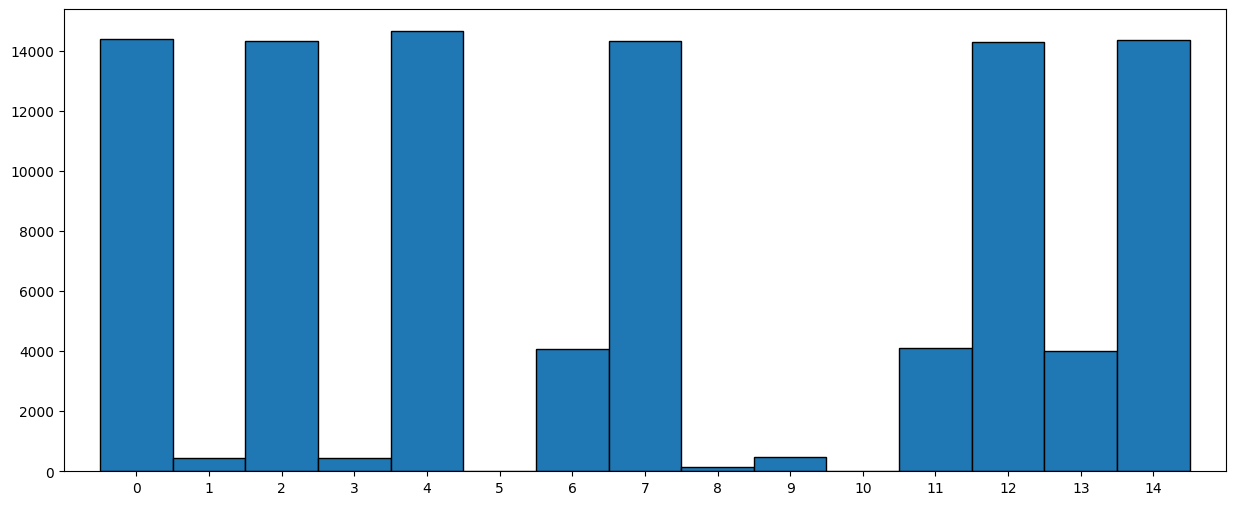

In [888]:
p_new=p_new/np.sum(p_new)



plt.figure(figsize=(15,6))
plt.hist(his,bins=range(min(his), max(his) + 2) ,align='left', edgecolor='black')
plt.xticks(range(max(his)+1))
plt.xlim([-1,max(his)+1])

In [889]:
bin_perm=perm_mat.copy()
bin_prob=prob_mat.copy()
# bin_prob

In [890]:
binn_comb=[]
for pp in bin_perm:
    a=pp[0:2]
    b=pp[2:]
    a=np.sum(a)
    b=np.sum(b)
    binn=[a,b]
    binn_comb.append(binn)

binn_comb



[[0, 0],
 [0, 2],
 [0, 4],
 [0, 2],
 [0, 4],
 [0, 4],
 [2, 0],
 [2, 2],
 [2, 2],
 [4, 0],
 [2, 0],
 [2, 2],
 [2, 2],
 [4, 0],
 [4, 0]]

In [891]:
unique_bin,counts_bin = np.unique(binn_comb,axis=0, return_counts=True)
(unique_bin)



array([[0, 0],
       [0, 2],
       [0, 4],
       [2, 0],
       [2, 2],
       [4, 0]])

In [892]:
ind_ar=[]
for u in unique_bin:
    for ind,b in enumerate(binn_comb):
        if np.array_equal(u, b):
            ind_ar.append(ind)
            break


last_prob=[]
for i in ind_ar:
  last_prob.append(bin_prob[i])


h_prob=np.multiply(last_prob,counts_bin)
# h_prob=last_prob

h_mat=h_prob/np.sum(h_prob)
(h_mat)

array([0.85547201, 0.053467  , 0.0037594 , 0.053467  , 0.03007519,
       0.0037594 ])

In [893]:
# h_mat=h_prob/np.sum(h_prob)



In [894]:
sum=[]
for u in unique_bin:
    ss=np.sum(u)
    sum.append(ss)
    
sorted_indices = np.argsort(np.array(sum))
sorted_indices.reshape(-1)
# Sort the array using the sorted indices
sort_arr=[]
new_bin_ar=[]
p_new=h_mat.copy()
for sor in sorted_indices:
    sort_arr.append(p_new[sor])
    new_bin_ar.append(unique_bin[sor])
# sorted_array
h_mat=sort_arr
h_mat

[0.8554720133667368,
 0.05346700083542415,
 0.05346700083542715,
 0.0037593984962409725,
 0.030075187969929473,
 0.0037593984962413975]

In [895]:
new_bin_ar

[array([0, 0]),
 array([0, 2]),
 array([2, 0]),
 array([0, 4]),
 array([2, 2]),
 array([4, 0])]

In [896]:
his=[]
for sam in range(100000):
    qq=np.random.choice(range(len(unique_bin)),p=h_mat)
    his.append(qq)




unique_bin


array([[0, 0],
       [0, 2],
       [0, 4],
       [2, 0],
       [2, 2],
       [4, 0]])

(-1.0, 6.0)

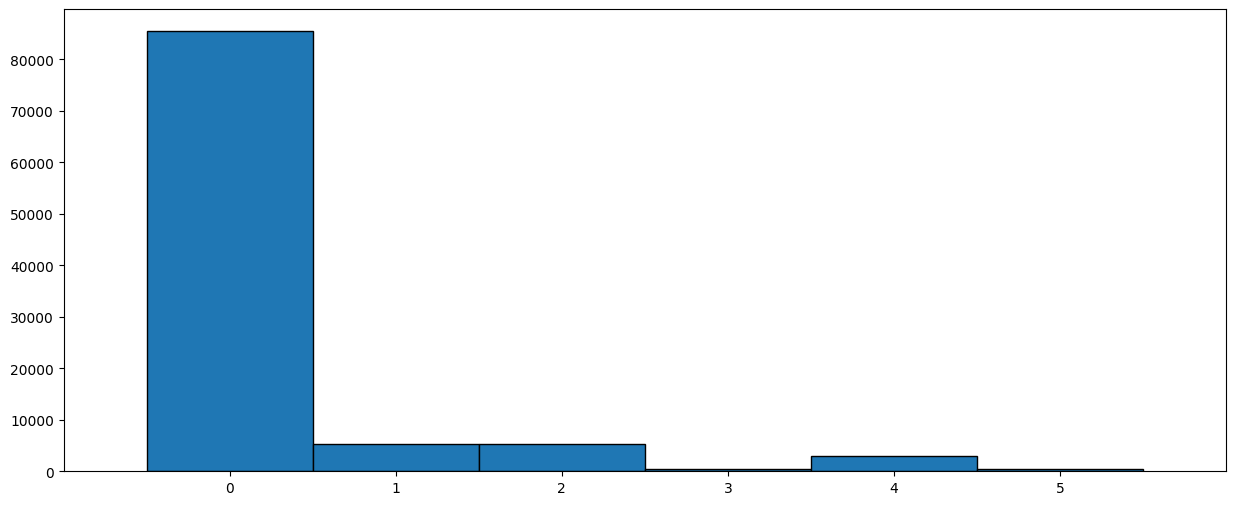

In [897]:


plt.figure(figsize=(15,6))
plt.hist(his,bins=range(min(his), max(his) + 2) ,align='left', edgecolor='black')
plt.xticks(range(max(his)+1))
plt.xlim([-1,max(his)+1])

In [898]:
len(perm_mat)
n_mat=[]
for g in perm_mat:
    if np.sum(g)==8:
        n_mat.append(g)

len(n_mat)

0

In [899]:
#det binning

In [900]:
c_ar=[0,2,4,6,8]

perm_dict={}
perm_mat=[[]]

prev_prob=[1]
B=[]


for m in range(8):
    m_array=np.array([m])
    inds = np.concatenate((m_array, (m_array + 8)))
    A=Cov[np.ix_(inds,inds)]
    Q=Qmat(A)
    dt=np.linalg.det(Q)
    det=1/(np.sqrt(dt.real))

    next_mat=[]
    inter_prob=[]
    pind=0
    prob_mat=[]
    for perm in perm_mat:
        
        
        for a in c_ar:         
            ar=perm.copy()
            ar.append(a) 

            if np.sum(ar)>8:
                break
            # elif m==max(range(8)):
                
            #     if np.sum(ar)!=8:
            #         None
            #     else:
            #         fact=1
            #         for factor in ar:
            #             fact=fact*factorial(factor)      
            #         As=sub_mat(A,ar)
            #         haf=hf._haf(As)
            #         prob=haf/(det*fact)
            #         prob=prob/prev_prob[pind]
                    
            #         prob_mat.append(prob.real)


            #         inter_prob.append(prob)         
            #         next_mat.append(ar)
            else:
                fact=1
                for factor in ar:
                    fact=fact*factorial(factor)      
                As=sub_mat(A,ar)
                haf=hf._haf(As)
                prob=haf/(det*fact)
                prob=prob/prev_prob[pind]
                
                prob_mat.append(prob.real)


                inter_prob.append(prob)         
                next_mat.append(ar)

        pind+=1
    prev_prob=inter_prob
    perm_mat=next_mat





In [901]:

tot_count_dict={}
total_haf_dict={}
for nind in range(comb_mat.shape[0]):
# for nind in range(1):

    ar=comb_mat[nind]
    aa=shuffle_array(ar)

    unique_rows,counts = np.unique(aa,axis=0, return_counts=True)
    rep_arr = unique_rows.tolist()  # matrix with each perm
    # length_unique_rows = len(rep_arr)

    count_dict = {tuple(arr): count for arr, count in zip(unique_rows, counts)}  # info about each perm and its count
       
    haf_dict={}
    for k,v in count_dict.items():    

        arr=np.array(k)
        fact=1
        for k_val in np.array(k):
            fact=fact*factorial(k_val)
        As=sub_mat(Cov_mat,arr)
        haf=hf._haf(As)
        haf_dict[k]=(v*haf/(fact*det)).real

    total_haf_dict.update(haf_dict)
    tot_count_dict.update(count_dict)

In [902]:
len(total_haf_dict)
total_haf_dict

{(0, 0, 2, 2): 0.10664286209147908,
 (0, 2, 0, 2): 0.35040366160687075,
 (0, 2, 2, 0): 0.42296542820856775,
 (2, 0, 0, 2): 1.7227768782523127,
 (2, 0, 2, 0): 0.65887698278515,
 (2, 2, 0, 0): 0.7323645184654348,
 (0, 0, 0, 4): 1.9263469969251368,
 (0, 0, 4, 0): 0.025950424894872898,
 (0, 4, 0, 0): 0.12889453055729078,
 (4, 0, 0, 0): 4.84297736904551}

In [903]:
s=0
for e,t in total_haf_dict.items():
    s+=t

s

10.918199652832627

In [904]:
y=0
for k,v in count_dict.items():  
    if y==0:
        print(np.array(k))
        y+=1
        fact=1
        for k_val in np.array(k):
            fact=fact*factorial(k_val)

fact

[0 0 0 4]


24.0

In [905]:
ar=comb_mat[0]
aa=shuffle_array(ar)
len(aa)

24

In [906]:

unique_rows,counts = np.unique(aa,axis=0, return_counts=True)
rep_arr = unique_rows.tolist()
length_unique_rows = len(rep_arr)
print("Unique Rows (rep_arr):")
print(rep_arr)
print("Length of Unique Rows:")
print(length_unique_rows)


Unique Rows (rep_arr):
[[0, 0, 2, 2], [0, 2, 0, 2], [0, 2, 2, 0], [2, 0, 0, 2], [2, 0, 2, 0], [2, 2, 0, 0]]
Length of Unique Rows:
6


In [907]:
count_dict = {tuple(arr): count for arr, count in zip(unique_rows, counts)}
len(count_dict)
count_dict

{(0, 0, 2, 2): 4,
 (0, 2, 0, 2): 4,
 (0, 2, 2, 0): 4,
 (2, 0, 0, 2): 4,
 (2, 0, 2, 0): 4,
 (2, 2, 0, 0): 4}

In [908]:
ii=0
for k,v in count_dict.items():
    if ii==0:
        print(np.array(k))
        ii+=1

[0 0 2 2]


In [909]:

A=Amat(Cov_mat)
Q=Qmat(Cov_mat)

In [910]:

def trans(A,arr):
    
    sum=np.sum(arr)
    D=np.eye(int(sum))
    j=0
    d=0 
    for a in arr:   
        if a==0:
            j+=1
        else:
            one=np.ones((a,a))*A[j,j]
            D[d:d+a,d:d+a]=one
            d+=a
            j+=1

    new_dict={}
    for (i, j), value in np.ndenumerate(A):
        new_dict[value]=[i,j]
    new_dict

    new_arr=D.copy()
    for (i, j), value in np.ndenumerate(D):
        if value==0:
            
            a=D[i,i]
            b=D[j,j]
            a_ind = new_dict[a]
            b_ind = new_dict[b]
        
            
        
            for key, (d_i, d_j) in new_dict.items():
                if (d_i, d_j) == (a_ind[0], b_ind[0]):
                    
                    new_arr[i, j] = key
   
    
    return new_arr



In [911]:
arr=[0,0,2,2,2,2,0,0]
T=trans(Cov_mat,arr)

In [912]:
from thewalrus import hafnian
hafnian(np.array(Cov_mat,dtype=np.complex128)).real

-0.03828195539065904

In [913]:
hf._haf(T)


(0.2617744037913923+0j)

In [914]:
def sub_mat(mat,arr):
    n=int(mat.shape[0]/2)
    A=mat[:n,:n]
    B=mat[:n,n:]
    C=mat[n:,n:]
    a_new=trans(A,arr)
    b_new=trans(B,arr)
    c_new=trans(C,arr)
    s=a_new.shape[0]
    As=np.eye(2*s)
    As[:s,:s]=a_new
    As[s:,:s]=b_new
    As[:s,s:]=b_new.T
    As[s:,s:]=c_new
    return As

In [915]:

mat=np.arange(36).reshape((6,6))
arr=[3,0,1]
As=sub_mat(mat,arr)
As


array([[ 0.,  0.,  0.,  2.,  3.,  3.,  3., 15.],
       [ 0.,  0.,  0.,  2.,  3.,  3.,  3., 15.],
       [ 0.,  0.,  0.,  2.,  3.,  3.,  3., 15.],
       [12., 12., 12., 14.,  5.,  5.,  5., 17.],
       [ 3.,  3.,  3.,  5., 21., 21., 21., 23.],
       [ 3.,  3.,  3.,  5., 21., 21., 21., 23.],
       [ 3.,  3.,  3.,  5., 21., 21., 21., 23.],
       [15., 15., 15., 17., 33., 33., 33., 35.]])

In [916]:
arr=np.array(ar)
As=sub_mat(Cov_mat,arr)


In [917]:

p1=pdf[0]
p2=pdf[1]
# Number of points
N = len(p1)

# Mean values
mean_p1 = np.mean(p1)
mean_p2 = np.mean(p2)

# Fluctuations
delta_p1 = p1 - mean_p1
delta_p2 = p2 - mean_p2

# Two-point correlation function
xi = np.outer(delta_p1, delta_p2) / N

print("Two-Point Correlation Function (xi):")
print(xi)


Two-Point Correlation Function (xi):
[[ 0.02324651 -0.00456274  0.00319694 -0.00456274 -0.00131494 -0.00456274
  -0.00305234 -0.00456274 -0.0038252 ]
 [-0.00293374  0.00057582 -0.00040346  0.00057582  0.00016595  0.00057582
   0.00038521  0.00057582  0.00048275]
 [-0.00271315  0.00053253 -0.00037312  0.00053253  0.00015347  0.00053253
   0.00035624  0.00053253  0.00044645]
 [-0.00293374  0.00057582 -0.00040346  0.00057582  0.00016595  0.00057582
   0.00038521  0.00057582  0.00048275]
 [-0.00293095  0.00057528 -0.00040308  0.00057528  0.00016579  0.00057528
   0.00038484  0.00057528  0.00048229]
 [-0.00293374  0.00057582 -0.00040346  0.00057582  0.00016595  0.00057582
   0.00038521  0.00057582  0.00048275]
 [-0.0029337   0.00057582 -0.00040345  0.00057582  0.00016594  0.00057582
   0.0003852   0.00057582  0.00048274]
 [-0.00293374  0.00057582 -0.00040346  0.00057582  0.00016595  0.00057582
   0.00038521  0.00057582  0.00048275]
 [-0.00293374  0.00057582 -0.00040346  0.00057582  0.000165

In [918]:
# plot_quantum_result(res, wl_ind=0, include_loss_modes=False)
# print('modes')

In [919]:
# mode_plot(res)
pdf

array([[4.38029249e-01, 0.00000000e+00, 3.69078028e-03, 0.00000000e+00,
        4.66470873e-05, 0.00000000e+00, 6.55070981e-07, 0.00000000e+00,
        9.65920738e-09],
       [6.43494302e-01, 0.00000000e+00, 1.79555870e-01, 0.00000000e+00,
        7.51529044e-02, 0.00000000e+00, 3.49501804e-02, 0.00000000e+00,
        1.70664178e-02],
       [6.12926952e-01, 0.00000000e+00, 1.30094856e-01, 0.00000000e+00,
        4.14193033e-02, 0.00000000e+00, 1.46522036e-02, 0.00000000e+00,
        5.44242432e-03],
       [4.35884686e-01, 0.00000000e+00, 3.19684177e-03, 0.00000000e+00,
        3.51691547e-05, 0.00000000e+00, 4.29892838e-07, 0.00000000e+00,
        5.51756919e-09]])

In [920]:
#sampler

def exp(pdf,N=4):
    # np.random.seed(42)
    mat=np.zeros((N,4))
    
    fock_num=range(pdf.shape[1])
    for n in range(N):
        arr=[]
        for i in range(pdf.shape[0]):
            P=pdf[i]/np.sum(pdf[i])
            ij=np.random.choice(fock_num,p=P)
            arr.append(ij)

        mat[n]=arr


    
    Mat=mat.T
    return Mat


##binning into two


def binning(pdf,binn=2):
    
    # np.random.seed(42)
    
    
    fock_num=range(pdf.shape[1])
    p=pdf.shape[0]
    b_arr=np.zeros(binn)
    r0=0
    r1=round(p/binn)
    r=r1


    for b in range(binn):

        arr=[]
        if r1>pdf.shape[1]:
            r1==pdf.shape[1]
        for i in range(r0,r1):
            P=pdf[i]/np.sum(pdf[i])
            ij=np.random.choice(fock_num,p=P)
            arr.append(ij)

        r0+=r
        r1+=r

        b_sum=np.sum(arr)
        if b_sum>4:
            b_sum=4
        b_arr[b]=b_sum
       


            
    return list(b_arr.astype(int))

    

def bin_exp(pdf,binn,num=100):

    B=[]
    for Num in range(num):
        ar=binning(pdf=pdf,binn=binn)
        B.append(ar)


    return B

In [921]:
exp(pdf,5)

array([[0., 0., 0., 0., 0.],
       [4., 6., 0., 0., 2.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [922]:
exp_res=bin_exp(pdf=pdf,binn=2,num=10000)


In [923]:
#x_arr
x_ar=[]
C_dict={}

cut_min=0
for cut in range(cutoff):
    c_ar=[]
    for c1 in range(cut+1):
        c2=cut-c1    
        ar=[c1,c2]
        c_ar.append(ar)
        cut_min+=1

    x_ar.extend(c_ar)



x_dict={}
xx=0
for x in x_ar:
    x_dict[xx]=[]
    x_dict[xx]=x
    xx+=1
    
hist_arr=[]

for c_key,c_val in x_dict.items():
    
    for e_arr in exp_res:
    
        if c_val==e_arr:
            hist_arr.append(c_key)
            
            
    
nn=range(100)
N=[]

for rr in hist_arr:
    if rr in nn:
        if  rr in N:
           None
        else:
         N.append(rr)
len(N)

9

In [924]:
len(x_dict)

45

(-1.0, 41.0)

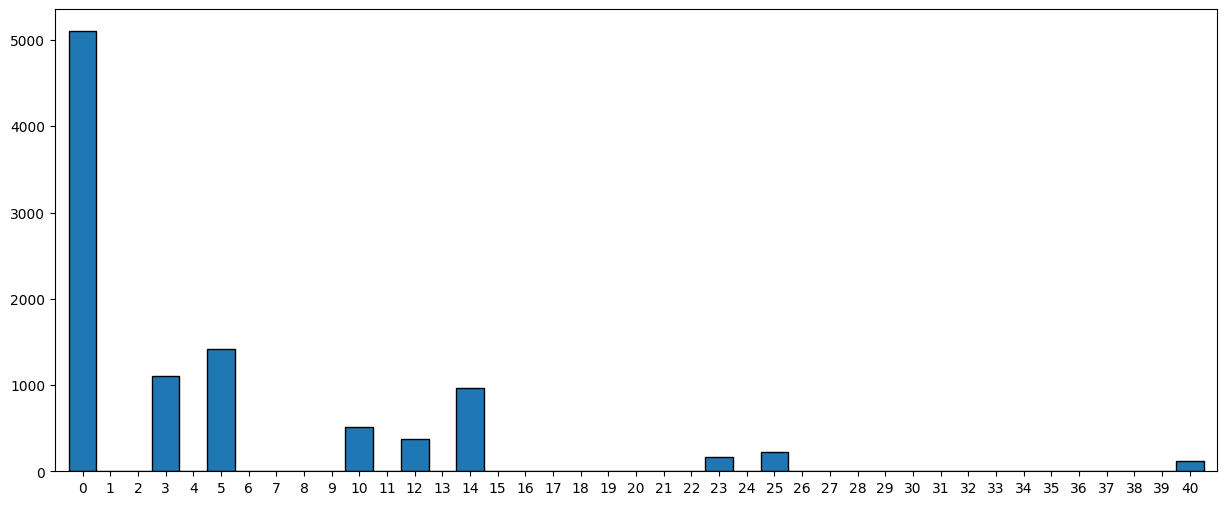

In [925]:
plt.figure(figsize=(15,6))


# plt.hist(hist_arr,bins=len(hist_arr))
plt.hist(hist_arr,bins=range(min(hist_arr), max(hist_arr) + 2) ,align='left', edgecolor='black')
# plt.ylim([0,1])
plt.xticks(range(max(hist_arr)+1))
plt.xlim([-1,max(hist_arr)+1])
# plt.ylim([0,200])
